In [1]:
import plyvel
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
import statsmodels.api as sm

from pyquery import PyQuery

from IPython.display import Markdown, display

def md(text):
    display(Markdown(text))

In [2]:
db = plyvel.DB("events.leveldb.db")

In [3]:
TYPES = {
    "content-edit": (" hat eine neue Version von ", " erstellt"),
    "content-associate": (" hat ", " assoziiert - "),
    "content-delete": (" hat ", " entfernt - "),
    "content-connect": (" hat ", " verknüpft - "),
    "content-update": (" hat ", " aktualisiert - "),
    "content-move": (" hat ", " verschoben - "),
    "content-archive": (" hat ", " archiviert - "),
    "content-recreated": (" hat ", " wiederhergestellt"),
    "content-create": (" hat ", " erstellt"),
    "review-approved": (" hat ", " ausgecheckt"),
    "review-disapproved": (" hat ", " abgelehnt"),
    "term-create": (" hat den Elter des Begriffs ", " geändert"),
    "comment": (" hat ", " kommentiert"),
    "template-notfound": ("Es wurde kein template für "),
    "license-change": (" hat die Lizenz von ", " geändert - "),
}

def convert(event):
    event = PyQuery(event.decode("utf-8"))
    event_text = event.text()
    
    event_timestamp = np.datetime64(event("abbr").text())
    event_type = None
    
    for k, v in TYPES.items():
        if all([x in event_text for x in v]):
            event_type = k
            break
        
    if not event_type:
        raise ValueError("TYPE NOT FOUND: " + event_text)
    
    if event_type != "template-notfound":
        event_author = event("a")[0].text
    else:
        event_author = None
        
    event_base_type = event_type.split("-")[0]
    
    return (event_timestamp, event_author, event_base_type, event_type)
    
data = [convert(e) for (_, e) in db.iterator(start=b"events-html", stop=b"events-html\xff")]
data.sort(key=lambda x: x[0])
data = pd.DataFrame(data, columns=["time", "author", "event_base", "event"])
data.index = data["time"]

In [4]:
data["event"] = data["event"].astype("category")
data["event_base"] = data["event_base"].astype("category")

In [5]:
data_no_legacy = data[data["author"] != "Legacy"]
data_edit = data_no_legacy[data_no_legacy["event"] == "content-edit"]

## Verlauf Anzahl aller Events pro Woche

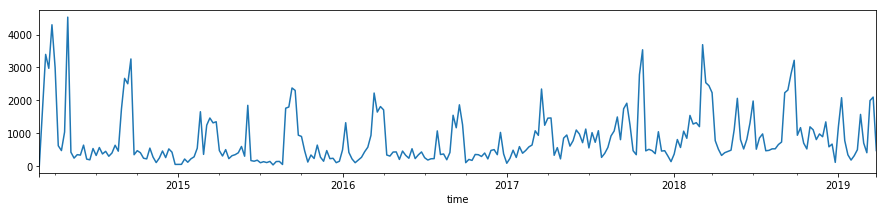

In [6]:
md("## Verlauf Anzahl aller Events pro Woche")
data_no_legacy.resample("W")["author"].count().plot(figsize=(15,3))

In [7]:
md("## Übersicht aller Events")
data_no_legacy["author"].describe()

## Übersicht aller Events

count     216532
unique       917
top       Renate
freq       12862
Name: author, dtype: object

## Verteilung der verschiedenen Arten von Events

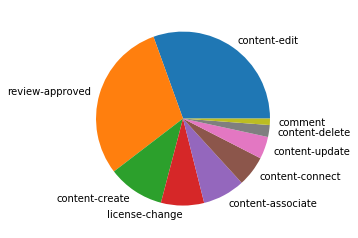

content-edit          65004
review-approved       63680
content-create        22403
license-change        17049
content-associate     16756
content-connect       12106
content-update         8803
content-delete         4720
comment                2526
content-move           1917
term-create             593
content-archive         424
template-notfound       397
review-disapproved      340
content-recreated       211
Name: event, dtype: int64

In [8]:
md("## Verteilung der verschiedenen Arten von Events")
data_no_legacy["event"].value_counts().head(9).plot(kind="pie")
plt.ylabel("")
plt.show()
data_no_legacy["event"].value_counts()

## Anzahl Events pro Jahr

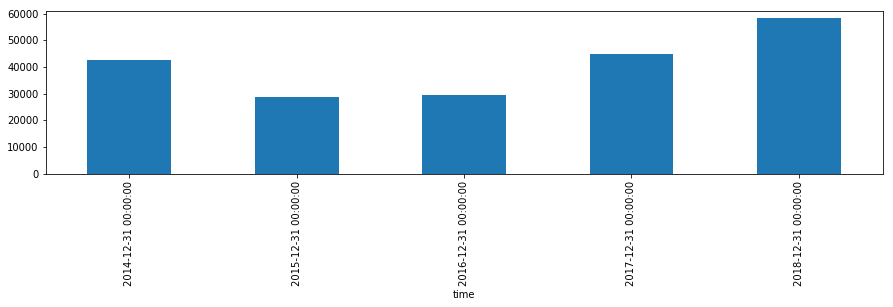

In [9]:
md("## Anzahl Events pro Jahr")
data_no_legacy.resample("Y")["author"].count()[:-1].plot(figsize=(15,3), kind="bar")

## Trends in der Anzahl der Events

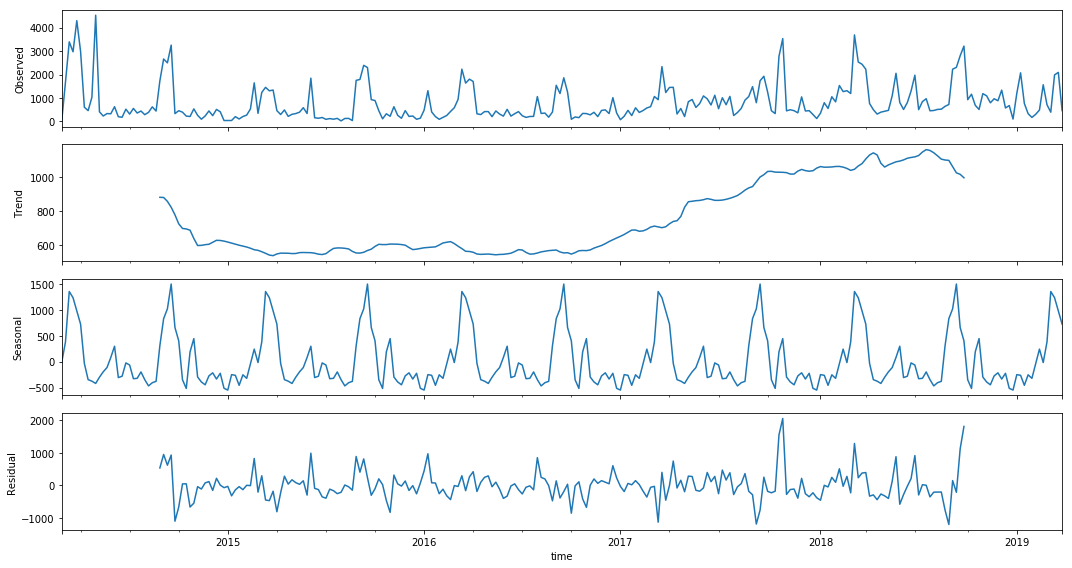

In [10]:
plt.rcParams["figure.figsize"] = (15,8)
dec = sm.tsa.seasonal_decompose(data_no_legacy.resample("W").count()["time"], model="additive")
md("## Trends in der Anzahl der Events")
dec.plot()
plt.show()

## Monatlicher Verlauf der verschiedenen Events (sortiert nach Typ)

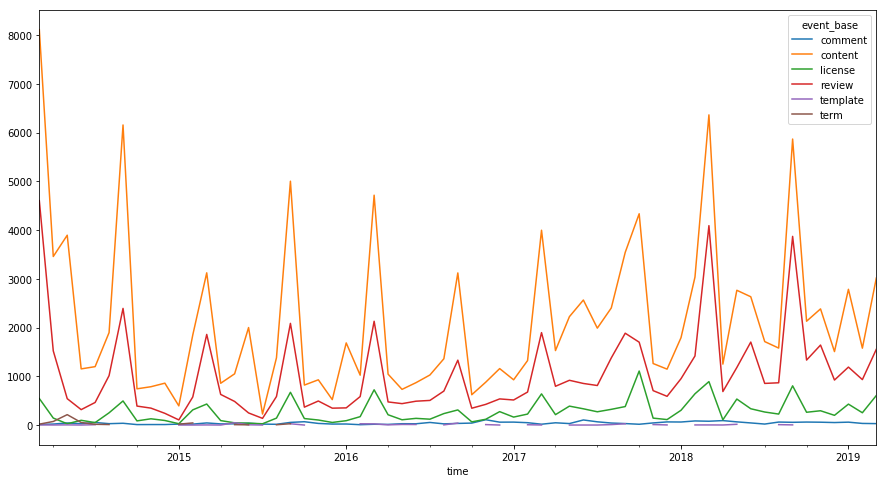

In [11]:
md("## Monatlicher Verlauf der verschiedenen Events (sortiert nach Typ)")
data_no_legacy.resample("M")["event_base"].value_counts().unstack().plot()

In [12]:
md("## 20 Top-Autorinnen (Alle-Events)")
data_no_legacy.groupby("author").count()["event"].sort_values(ascending=False).head(20)

## 20 Top-Autorinnen (Alle-Events)

author
Renate        12862
Nish           9739
chdieter       7190
Simon          6221
metzgaria      5794
kazuki         4934
Knorrke        4623
Kati_L         4485
Jonathan       4051
Rebi           3890
LeaFa          3567
Katha26        3543
Hannes         3402
Lena09         3260
tobi_serlo     3244
Tinsaye        3217
NiCi           3129
Niggo          2883
Karin          2813
wolfgang       2754
Name: event, dtype: int64

In [13]:
md("## 20 Top-Autorinnen (Nur Bearbeitungen)")
data_edit.groupby("author").count()["event"].sort_values(ascending=False).head(20)

## 20 Top-Autorinnen (Nur Bearbeitungen)

author
chdieter         2485
Nish             2320
Simon            1961
Renate           1792
Jonathan         1462
Kati_L           1371
metzgaria        1348
kazuki           1181
Knorrke          1110
LeaFa            1072
Niggo             985
Lena09            933
Rebi              910
Tinsaye           894
adrian_wagner     874
tobi_serlo        862
Karin             855
Katha26           848
haberlm           804
Manuel_Voigt      747
Name: event, dtype: int64

## Verlauf wöchentliche Anzahl Bearbeitungen

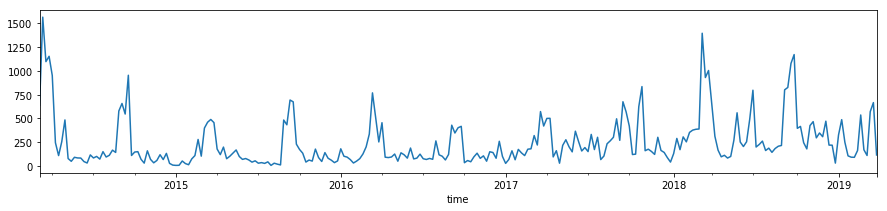

In [14]:
md("## Verlauf wöchentliche Anzahl Bearbeitungen")
data_edit.resample("W")["author"].count().plot(figsize=(15,3))

## Trend wöchentliche Bearbeitungen

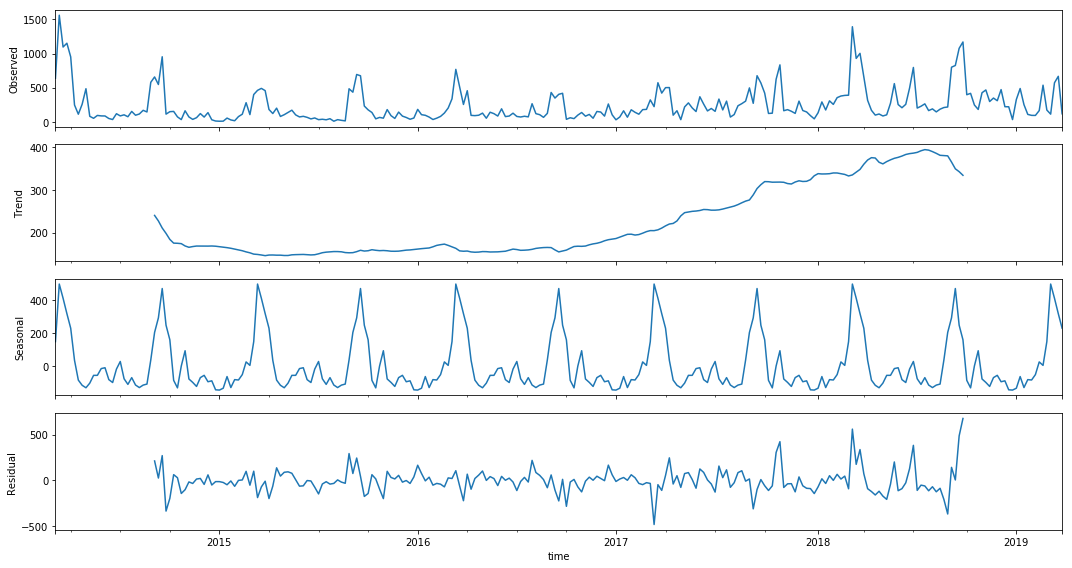

In [15]:
plt.rcParams["figure.figsize"] = (15,8)
dec = sm.tsa.seasonal_decompose(data_edit.resample("W").count()["time"], model="additive")
md("## Trend wöchentliche Bearbeitungen")
dec.plot()
plt.show()

In [16]:
last90 = data.truncate(before=pd.Timestamp.now() + pd.Timedelta("-90 days"))

a = last90[last90["event_base"] == "content"].groupby("author")["time"].count()

md("## Aktuelle aktive Autor*innen")
md("Anzahl: %s" % a[a > 10].count())
a[a > 10]

## Aktuelle aktive Autor*innen

Anzahl: 58

author
2817                 30
Alex_Lueckenhaus     61
Bettina_G            77
Daniel-I            427
Daphne_s             14
Dominik_Kerpes       13
Felix96             165
Greta                13
Hendrik_Arl          12
I_M_MEEN             27
Isabel_Domagala     555
Jojuacamole          79
Jonathan            774
JuliaStaat           34
Karin               365
Karin2406            78
Kati_L              120
Knorrke              25
Kowalsky             56
Kulla                34
Laura                62
Leo1                 49
Liv_a                57
Maria_F             273
Martin_Gast          53
MaxHerzog            12
Michi_pi             11
Nanami               24
Niggo               308
Nish                130
Quatematik           63
Renate               33
Ronnit               81
Simon                49
Simone_Heinrich      77
ThomasBrunner       139
Valentin01           12
Vithusha            134
_Wasserfall_Pia_     36
abcd                 14
botho               189
chdieter 

## Verlauf aktive Autor*innen

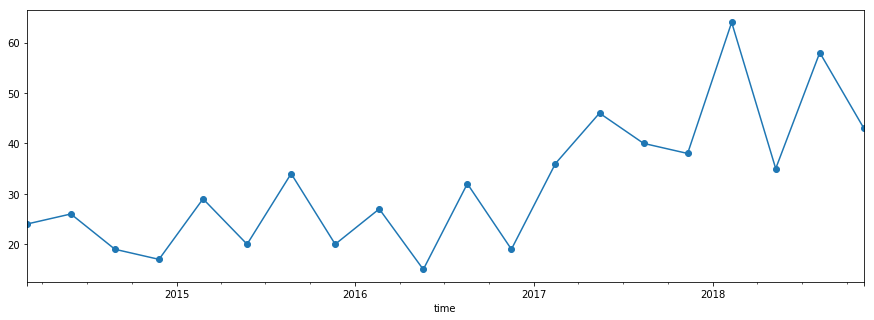

In [17]:
md("## Verlauf aktive Autor*innen")
a = data_no_legacy[data_no_legacy["event_base"] == "content"].resample("90D")["author"].value_counts()
a[a[:,:] > 10].count("time")[:-1].plot(marker="o", figsize=(15,5))

In [18]:
last90 = data.truncate(before=pd.Timestamp.now() + pd.Timedelta("-90 days"))

a = last90[last90["event_base"] == "content"].groupby("author")["time"].count()

md("## Aktuelle sehr aktive Autor*innen")
md("Anzahl: %s" % a[a > 100].count())
a[a > 100]

## Aktuelle sehr aktive Autor*innen

Anzahl: 20

author
Daniel-I           427
Felix96            165
Isabel_Domagala    555
Jonathan           774
Karin              365
Kati_L             120
Maria_F            273
Niggo              308
Nish               130
ThomasBrunner      139
Vithusha           134
botho              189
chdieter           117
emir_nbh           716
hernlmax           136
julien_grenier     161
markus_janker      196
moritz0312         548
opamp              138
wolfgang           159
Name: time, dtype: int64

## Verlauf sehr aktive Autor*innen

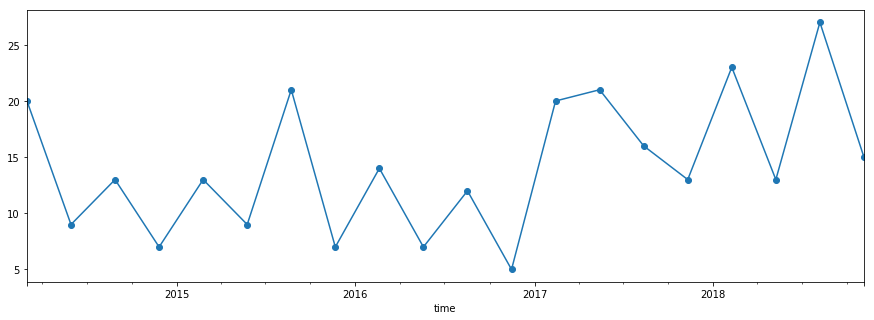

In [19]:
md("## Verlauf sehr aktive Autor*innen")
a = data_no_legacy[data_no_legacy["event_base"] == "content"].resample("90D")["author"].value_counts()
a[a[:,:] > 100].count("time")[:-1].plot(marker="o", figsize=(15,5))

In [20]:
md("## Langfristige Autor*innen")
last = data.truncate(before=pd.Timestamp.now() + pd.Timedelta("-270 days")).resample("90D")
a = last["author"].value_counts()[:-1]
p = a[a[:,:] > 10].unstack().transpose().dropna()

md("Anzahl: %s" % len(p))
p

## Langfristige Autor*innen

Anzahl: 23

time,2018-06-29 00:00:00,2018-09-27 00:00:00,2018-12-26 00:00:00
author,,,
Niggo,1366.0,133.0,542.0
Nish,855.0,291.0,273.0
Vithusha,760.0,22.0,247.0
tobi_serlo,713.0,73.0,71.0
metzgaria,706.0,284.0,107.0
Simone_Heinrich,669.0,662.0,140.0
Renate,640.0,320.0,83.0
Karin,619.0,277.0,627.0
Bettina_G,546.0,84.0,146.0


# Reviewing

In [21]:
reviewing = data_no_legacy[data_no_legacy["event_base"] == "review"]

In [22]:
md("## 30 Top-Autorinnen (Nur Reviews)")
reviewing.groupby("author").count()["event"].sort_values(ascending=False).head(30)

## 30 Top-Autorinnen (Nur Reviews)

author
Nish             3407
chdieter         2490
Renate           2360
Simon            2064
metzgaria        1975
Jonathan         1506
Kati_L           1381
Rebi             1339
Knorrke          1228
LeaFa            1057
kazuki           1017
Niggo             985
Tinsaye           923
Lena09            914
tobi_serlo        886
adrian_wagner     861
Katha26           844
haberlm           790
Karin             761
Hannes            748
Manuel_Voigt      747
wolfgang          669
LorenzHuber       668
lotta_behrens     650
Marvin            641
NiCi              627
Lenali            621
Viki              604
Michi             594
Tobias            593
Name: event, dtype: int64

In [23]:
md("## 30 Top-Autorinnen (Nur Reviews; letzte 6 Monate)")
reviewing.truncate(before=pd.Timestamp.now() + pd.Timedelta("-180days")).groupby("author").count()["event"].sort_values(ascending=False).head(30)

## 30 Top-Autorinnen (Nur Reviews; letzte 6 Monate)

author
Jonathan            1506
emir_nbh             345
SinaDE               326
ThomasBrunner        300
Isabel_Domagala      294
Viki                 292
Simone_Heinrich      279
Karin                270
chdieter             267
moritz0312           256
Nish                 214
Jojuacamole          213
Niggo                212
Kati_L               188
botho                187
Daniel-I             179
metzgaria            166
kathongi             163
Renate               144
Maria_F              132
Ronnit               127
wolfgang             124
Alex_Lueckenhaus     114
Vithusha             103
Bettina_G            100
Kulla                 99
markus_janker         96
julien_grenier        93
hernlmax              91
opamp                 80
Name: event, dtype: int64

In [ ]:
from itertools import count

def convert2(event):
    event = PyQuery(event.decode("utf-8"))
    event_text = event.text()
    
    event_timestamp = np.datetime64(event("abbr").text())
    event_type = None
    
    for k, v in TYPES.items():
        if all([x in event_text for x in v]):
            event_type = k
            break
        
    if not event_type:
        raise ValueError("TYPE NOT FOUND: " + event_text)
    
    links = [None, None, None]
    names = [None, None, None]
    types = ["X", "Y", "Z"]
    i = 0
    
    relation = ""
    
    for child in event.contents():
        if isinstance(child, str):
            child = child.strip()
            
            if child:
                relation += child
        else:
            if child.tag == "a":
                links[i] = child.get("href")
                names[i] = child.text
                relation += " %s " % types[i]
                
                i += 1
    
    if event_type != "template-notfound":
        event_author = event("a")[0].text
    else:
        event_author = None
        
    event_base_type = event_type.split("-")[0]
    
    return (event_timestamp, event_author, relation.strip(), event_base_type, event_type, links[0], names[0], links[1], names[1], links[2], names[2])

convert2(next(db.iterator(start=b"events-html", stop=b"events-html\xff"))[1])

data2 = [convert2(e) for (_, e) in db.iterator(start=b"events-html", stop=b"events-html\xff")]
data2.sort(key=lambda x: x[0])
data2 = pd.DataFrame(data2, columns=["time", "author", "relation", "event_base", "event", "link_X", "value_X", "link_Y", "value_Y", "link_Z", "value_Z"])
data2.index = data2["time"]
data2.to_csv("serlo-events.csv")